<a href="https://colab.research.google.com/github/Teodosiodg2002/Diabetes-Classification/blob/main/DiabetesClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Librerías y Configuración Global
Todo lo que se importa va al principio. Definimos las constantes (rutas, semillas) arriba para no tener "números mágicos" escondidos en el código.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, RocCurveDisplay)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Configuración Global
CONFIG = {
    'FILENAME': 'diabetes.csv',
    'SEP': ';',
    'TARGET': 'Diabetes_binary',
    'SEED': 42,
    'TEST_SIZE': 0.2,    # 20% para Test final
    'VAL_SIZE': 0.15     # 15% para Validación (del total)
}

# Estilo de gráficas
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Funciones de Carga y Pre-procesamiento
Aquí encapsulamos la lógica. La función preprocess_data: ahora devuelve los 3 conjuntos limpios y listos. Esto cumple con el requisito de limpieza y tratamiento de nulos .

In [36]:
# ==========================================
# 2. FUNCIONES DE CARGA Y LIMPIEZA
# ==========================================

def load_data(filename, sep):
    """Carga datos y gestiona valores centinela."""
    try:
        df = pd.read_csv(filename, sep=sep)
        print(f"📂 Dataset cargado: {df.shape}")

        # Tratamiento de nulos especificado en la práctica (-999 a NaN)
        df.replace(-999, np.nan, inplace=True)

        # Imputación por mediana (Estrategia robusta)
        if df.isnull().sum().sum() > 0:
            df.fillna(df.median(), inplace=True)
            print("✨ Valores nulos imputados por la mediana.")

        return df
    except FileNotFoundError:
        print("❌ Error: Archivo no encontrado.")
        return None

def preprocess_and_split(df, target_col):
    """Normaliza numéricos y divide en Train/Val/Test."""

    # 1. Normalización Min-Max (solo numéricas no binarias)
    scaler = MinMaxScaler()
    cols_to_scale = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

    df_scaled = df.copy()
    # Verificamos que las columnas existan antes de escalar
    cols_existentes = [c for c in cols_to_scale if c in df.columns]
    df_scaled[cols_existentes] = scaler.fit_transform(df[cols_existentes])

    # 2. Separación X / y
    X = df_scaled.drop(target_col, axis=1)
    y = df_scaled[target_col]

    # 3. División: Train (70%) - Temp (30%)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=CONFIG['SEED'], stratify=y
    )

    # 4. División: Val (15%) - Test (15%)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=CONFIG['SEED'], stratify=y_temp
    )

    print(f"📊 División completada:")
    print(f"   - Train: {X_train.shape[0]} muestras")
    print(f"   - Val:   {X_val.shape[0]} muestras")
    print(f"   - Test:  {X_test.shape[0]} muestras")

    return X_train, X_val, X_test, y_train, y_val, y_test

def find_optimal_k(X_train):
    """
    Muestra la gráfica del codo para decidir el número de clusters.
    """
    print("\n🕵️ Buscando el número óptimo de clusters (Método del Codo)...")
    inertias = []
    k_range = range(2, 11)

    # Usamos una muestra para que sea rápido
    X_sample = X_train.sample(n=min(10000, len(X_train)), random_state=CONFIG['SEED'])

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=CONFIG['SEED'], n_init=10)
        kmeans.fit(X_sample)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8, 4))
    plt.plot(k_range, inertias, 'bo-', markersize=8)
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Inercia')
    plt.title('Método del Codo')
    plt.grid(True)
    plt.show()

def add_cluster_feature(X_train, X_val, X_test, n_clusters=3):
    """
    Entrena K-Means en Train y añade 'Cluster_ID' a todos los sets.
    """
    print(f"\n🧪 Aplicando Clustering (k={n_clusters})...")

    # 1. Entrenar solo en Train
    kmeans = KMeans(n_clusters=n_clusters, random_state=CONFIG['SEED'], n_init=10)
    kmeans.fit(X_train)

    # 2. Copiar para no modificar originales
    X_train_new, X_val_new, X_test_new = X_train.copy(), X_val.copy(), X_test.copy()

    # 3. Asignar clusters
    X_train_new['Cluster_ID'] = kmeans.predict(X_train)
    X_val_new['Cluster_ID'] = kmeans.predict(X_val)
    X_test_new['Cluster_ID'] = kmeans.predict(X_test)

    print(f"   - Variable 'Cluster_ID' añadida. Nuevas columnas: {X_train_new.shape[1]}")
    return X_train_new, X_val_new, X_test_new

def add_interaction_features(df):
    """
    Crea nuevas variables basadas en combinaciones lógicas (médicas).
    """
    print("\n💊 Creando variables de interacción médica...")
    df_new = df.copy()

    # 1. Comorbilidad (Suma de condiciones de riesgo)
    # Si tienes Presión Alta Y Colesterol, el riesgo se dispara.
    df_new['Comorbidity_Score'] = df_new['HighBP'] + df_new['HighChol'] + df_new['HeartDiseaseorAttack']

    # 2. Impacto del Peso en la Edad (Interaction term)
    # Un BMI alto es más peligroso cuanto mayor eres.
    df_new['BMI_x_Age'] = df_new['BMI'] * df_new['Age']

    # 3. Estilo de vida (Fumar + Alcohol)
    df_new['Bad_Habits'] = df_new['Smoker'] + df_new['HvyAlcoholConsump']

    # 4. Salud General vs Salud Física
    # Relación entre cómo te sientes y tus días enfermos
    df_new['Hlth_Risk_Score'] = df_new['GenHlth'] * df_new['PhysHlth']

    print(f"   - Variables creadas: 'Comorbidity_Score', 'BMI_x_Age', 'Bad_Habits', 'Hlth_Risk_Score'")
    return df_new

def select_top_features(model, X_train, X_val, X_test, threshold=0.01):
    """
    1. Analiza la importancia de cada variable según el modelo.
    2. Elimina las que contribuyen menos que el 'threshold' (umbral).
    3. Devuelve los datasets reducidos.
    """
    print(f"\n✂️ SELECCIÓN DE VARIABLES (Umbral: {threshold})...")

    # Obtenemos importancias
    importances = model.feature_importances_
    feature_names = X_train.columns

    # Creamos un DataFrame para visualizar
    feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

    # Mostramos las Top 5 y las Bottom 5
    print("   🔝 Top 5 Variables más importantes:")
    print(feature_imp_df.head(5).to_string(index=False))
    print("   🔻 Bottom 5 Variables (Candidatas a eliminación):")
    print(feature_imp_df.tail(5).to_string(index=False))

    # Filtramos: Nos quedamos solo con las que superan el umbral
    # OJO: Si el umbral es muy alto, nos quedamos sin variables.
    # Usaremos una lógica dinámica: "Quédate con el Top 15" si el umbral es muy agresivo.

    vars_to_keep = feature_imp_df[feature_imp_df['Importance'] > threshold]['Feature'].tolist()

    if len(vars_to_keep) < 5:
        print("   ⚠️ El umbral fue muy estricto. Manteniendo el Top 10 por seguridad.")
        vars_to_keep = feature_imp_df.head(10)['Feature'].tolist()

    print(f"   ✅ Variables seleccionadas: {len(vars_to_keep)} de {len(feature_names)}")
    print(f"   🗑️ Eliminadas: {set(feature_names) - set(vars_to_keep)}")

    # Filtramos los dataframes
    return X_train[vars_to_keep], X_val[vars_to_keep], X_test[vars_to_keep]

## 3. Función Maestra de Evaluación
Esta es la "joya" del código limpio. En lugar de repetir código para cada modelo, creamos una función que recibe un modelo, lo entrena y saca todas las gráficas .

In [37]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name="Modelo"):
    """
    1. Entrena el modelo.
    2. Realiza Cross-Validation.
    3. Muestra métricas y gráficas en el conjunto de Validación.
    """
    print(f"\n🚀 Entrenando {model_name}...")

    # A. Cross-Validation (5 Folds) para verificar estabilidad
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=CONFIG['SEED'])
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"   - Accuracy CV (Media): {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

    # B. Entrenamiento final
    model.fit(X_train, y_train)

    # C. Evaluación en Validación
    acc_val = model.score(X_val, y_val)
    print(f"   - Accuracy Validation: {acc_val:.4f}")

    # D. Gráficas
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Matriz de Confusión
    ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Matriz de Confusión - {model_name}')
    axes[0].grid(False)

    # Curva ROC
    RocCurveDisplay.from_estimator(model, X_val, y_val, ax=axes[1], name=model_name)
    axes[1].set_title(f'Curva ROC - {model_name}')
    axes[1].plot([0, 1], [0, 1], 'r--', label='Azar')

    plt.tight_layout()
    plt.show()

    return model

## 4. Ejecución Principal (Main Loop)
Aquí es donde "ocurre la magia". Es limpio, corto y fácil de leer.

In [38]:
def main():
    # 1. Carga
    df = load_data(CONFIG['FILENAME'], CONFIG['SEP'])

    if df is not None:
        # Pre-procesamiento inicial
        X_train, X_val, X_test, y_train, y_val, y_test = preprocess_and_split(df, CONFIG['TARGET'])

        # --- PASO PREVIO: OBTENER DATASET REDUCIDO (El ganador de la Fase 4) ---
        print("\n--- 🛠️ PREPARANDO DATOS (Aplicando selección de variables) ---")

        # Entrenamos un RF rápido solo para seleccionar variables
        rf_selector = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=CONFIG['SEED'], n_jobs=-1)
        rf_selector.fit(X_train, y_train)

        # Nos quedamos con las mejores (usamos el umbral que te funcionó: 0.015)
        X_train_sel, X_val_sel, X_test_sel = select_top_features(rf_selector, X_train, X_val, X_test, threshold=0.015)


        # --- FASE 5: DUELO DE MODELOS (RF vs BOOSTING) ---
        print("\n--- 🥊 FASE 5: DUELO DE MODELOS (Datos Simplificados) ---")

        # CONTENDIENTE 1: Random Forest (El campeón actual)
        rf_final = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=CONFIG['SEED'], n_jobs=-1)
        model_rf = train_and_evaluate(rf_final, X_train_sel, y_train, X_val_sel, y_val, "RF (Simplificado)")

        # CONTENDIENTE 2: HistGradientBoosting (El aspirante)
        gb_model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, max_depth=10, random_state=CONFIG['SEED'])
        model_gb = train_and_evaluate(gb_model, X_train_sel, y_train, X_val_sel, y_val, "Gradient Boosting")

        # --- CONCLUSIÓN DEL DUELO ---
        acc_rf = model_rf.score(X_val_sel, y_val)
        acc_gb = model_gb.score(X_val_sel, y_val)

        print("\n🏆 RESULTADO DEL DUELO:")
        print(f"   Random Forest:     {acc_rf:.4f}")
        print(f"   Gradient Boosting: {acc_gb:.4f}")

        # Determinamos el ganador provisional
        if acc_gb > acc_rf:
            print(f"✅ NUEVO LÍDER: El Boosting mejoró el modelo en {(acc_gb - acc_rf)*100:.2f}%.")
            modelo_base_optimizacion = HistGradientBoostingClassifier(random_state=CONFIG['SEED'])
        else:
            print("🛡️ DEFENSA: El Random Forest sigue siendo el mejor (pero intentaremos optimizar el Boosting por su potencial).")
            modelo_base_optimizacion = HistGradientBoostingClassifier(random_state=CONFIG['SEED'])


        # --- FASE 6: EL ÚLTIMO INTENTO (GRID SEARCH) ---
        # Independientemente de quien ganara por poco, el Boosting suele tener más margen de mejora
        print("\n--- 🔧 FASE 6: AJUSTE FINO (Grid Search sobre Boosting) ---")
        print("⏳ Probando combinaciones de hiperparámetros (esto tardará unos minutos)...")

        # Definimos la rejilla de parámetros a probar
        param_grid = {
            'learning_rate': [0.05, 0.1, 0.2],    # Qué tan rápido aprende
            'max_depth': [10, 15],                # Profundidad del árbol
            'l2_regularization': [0, 0.1],        # Evitar overfitting
            'max_iter': [100, 200]                # Número de árboles
        }

        # Configuramos la búsqueda exhaustiva
        grid_search = GridSearchCV(
            estimator=modelo_base_optimizacion,
            param_grid=param_grid,
            cv=3,                 # Validación cruzada de 3 pliegues (para no tardar demasiado)
            scoring='accuracy',
            n_jobs=-1,            # Usar todos los núcleos del procesador
            verbose=1
        )

        # Entrenamos buscando la mejor combinación
        grid_search.fit(X_train_sel, y_train)

        print(f"   ✅ Mejores parámetros encontrados: {grid_search.best_params_}")
        print(f"   ✅ Mejor Accuracy CV (Entrenamiento): {grid_search.best_score_:.4f}")

        # --- EVALUACIÓN FINAL DEFINITIVA ---
        # Usamos el mejor modelo encontrado por el GridSearch para el test final
        best_model = grid_search.best_estimator_

        print("\n📜 EVALUACIÓN FINAL (Sobre Test Set - Datos nunca vistos)")
        acc_test = best_model.score(X_test_sel, y_test)
        print(f"   Accuracy Real (Test): {acc_test:.4f}")

        # Matriz de confusión final
        print("\n📊 Generando Matriz de Confusión Final...")
        fig, ax = plt.subplots(figsize=(6, 5))
        ConfusionMatrixDisplay.from_estimator(best_model, X_test_sel, y_test, cmap='Oranges', ax=ax)
        plt.title(f"Matriz Final (Accuracy: {acc_test:.4f})")
        plt.grid(False)
        plt.show()

📂 Dataset cargado: (60796, 22)
✨ Valores nulos imputados por la mediana.
📊 División completada:
   - Train: 42557 muestras
   - Val:   9119 muestras
   - Test:  9120 muestras

--- 🛠️ PREPARANDO DATOS (Aplicando selección de variables) ---

✂️ SELECCIÓN DE VARIABLES (Umbral: 0.015)...
   🔝 Top 5 Variables más importantes:
 Feature  Importance
  HighBP    0.208744
 GenHlth    0.201048
     BMI    0.138236
     Age    0.100533
HighChol    0.091501
   🔻 Bottom 5 Variables (Candidatas a eliminación):
      Feature  Importance
       Smoker    0.006667
       Fruits    0.005624
      Veggies    0.005454
  NoDocbcCost    0.004356
AnyHealthcare    0.003561
   ✅ Variables seleccionadas: 11 de 21
   🗑️ Eliminadas: {'Smoker', 'CholCheck', 'Sex', 'PhysActivity', 'AnyHealthcare', 'Veggies', 'NoDocbcCost', 'HvyAlcoholConsump', 'Stroke', 'Fruits'}

--- 🥊 FASE 5: DUELO DE MODELOS (Datos Simplificados) ---

🚀 Entrenando RF (Simplificado)...
   - Accuracy CV (Media): 0.7435 (+/- 0.0108)
   - Accuracy Va

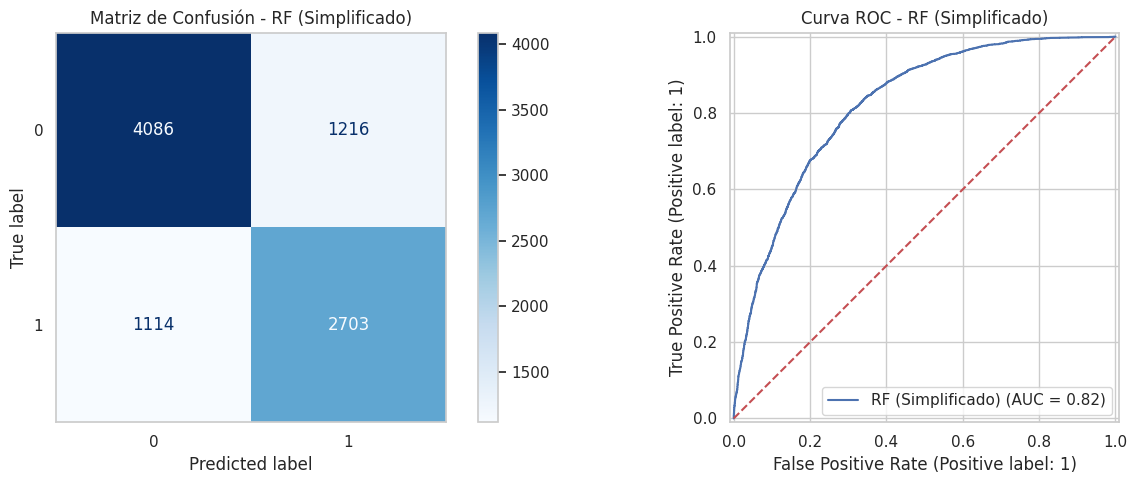


🚀 Entrenando Gradient Boosting...
   - Accuracy CV (Media): 0.7456 (+/- 0.0090)
   - Accuracy Validation: 0.7478


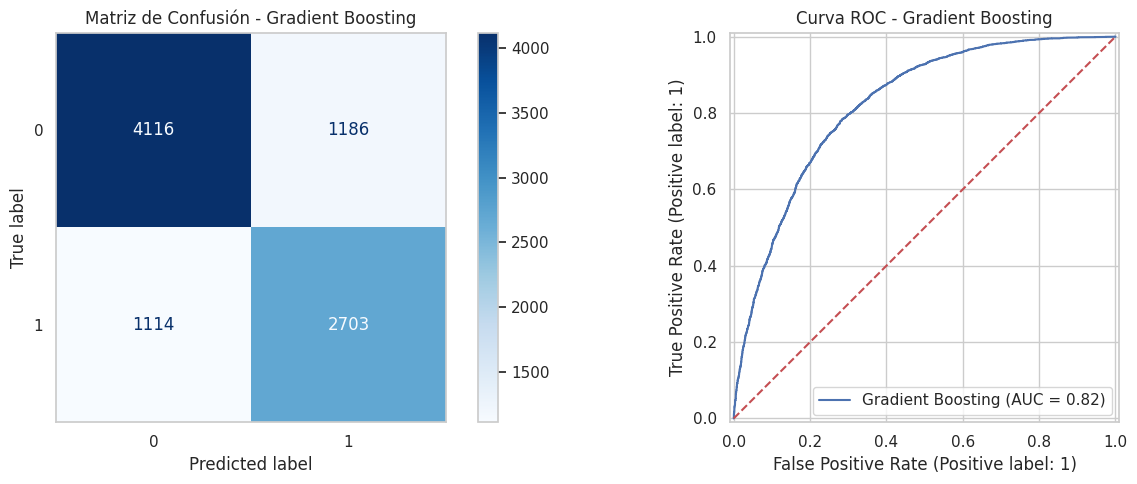


🏆 RESULTADO DEL DUELO:
   Random Forest:     0.7445
   Gradient Boosting: 0.7478
✅ NUEVO LÍDER: El Boosting mejoró el modelo en 0.33%.

--- 🔧 FASE 6: AJUSTE FINO (Grid Search sobre Boosting) ---
⏳ Probando combinaciones de hiperparámetros (esto tardará unos minutos)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
   ✅ Mejores parámetros encontrados: {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_depth': 10, 'max_iter': 200}
   ✅ Mejor Accuracy CV (Entrenamiento): 0.7462

📜 EVALUACIÓN FINAL (Sobre Test Set - Datos nunca vistos)
   Accuracy Real (Test): 0.7447

📊 Generando Matriz de Confusión Final...


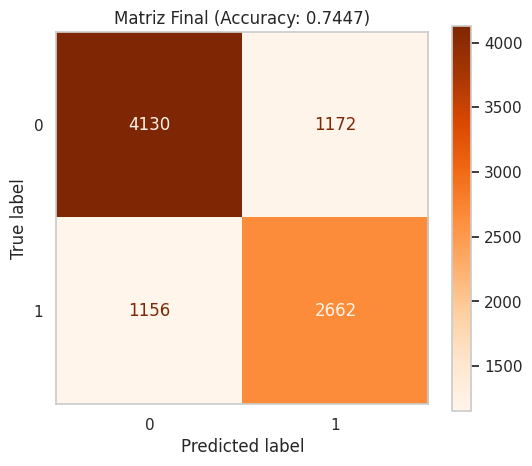

In [39]:
if __name__ == "__main__":
    main()